In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")
sys.path.append("../../CompoTree/src")

In [3]:
from gensim.models import KeyedVectors
from fluidvec import create_fluid_keyvec, VocabSet
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [4]:
vs = VocabSet.load()
wvocab = vs.word_vocab

In [5]:
fkv = create_fluid_keyvec("../data/model/fluidvec-char.b.1", "../data/model/fluidvec-compo.b.1")
fkv

device:  cpu
n_neg_sample:  5
device:  cpu
n_neg_sample:  5


<FluidKeyedVectors: 217350 words, 20396 chars, 3504 compos, 100 dimensions>

## Load CLP

In [6]:
clp = pd.read_excel("../data/behavioral/Tse-2017-Chinese-lexicon-project.xlsx", sheet_name="Word")

In [7]:
def get_asbc_wfreq(w):
    widx = vs.word_vocab.encode(w)
    if widx >= 0:
        return vs.word_vocab.freq[widx]
    else:
        return 0

def compute_word_to_prefix(w, c1):
    if f"/{c1}." not in fkv:
        return None
    else:
        return fkv.similarity(w, f"/{c1}.")

def compute_word_to_suffix(w, c2):
    if f".{c2}/" not in fkv:
        return None
    else:
        return fkv.similarity(w, f".{c2}/")

def compute_prefix_to_suffix(c1, c2):
    if (f".{c2}/" not in fkv) or (f"/{c1}." not in fkv):
        return None
    else:
        return fkv.similarity(f"/{c1}.", f".{c2}/")
    
def compute_word_to_char(w, ch):
    if f"/{ch}/" not in fkv:
        return None
    else:
        return fkv.similarity(w, f"/{ch}/")
    

In [8]:
subdfr = clp.loc[clp["Word_Trad"].apply(lambda x: x in fkv), ["Word_Trad", "RT", "ST-C1", "ST-C2"]]
subdfr["RTinv"] = -1000 / subdfr["RT"]
subdfr.insert(2, "RTinv", subdfr.pop("RTinv"))
clp.shape, subdfr.shape

((25281, 28), (23459, 5))

In [9]:
c1type_cache = {}
c2type_cache = {}
cvocab = vs.char_vocab
wvocab = vs.word_vocab
words = list(wvocab.vocab.keys())

def compute_morph_freq(row):
    word = row.Word_Trad
    if word[0] not in c1type_cache:
        c1type_cache[word[0]] = len([x for x in words if len(x) == 2 and x[0]==word[0]])
    if word[1] not in c2type_cache:
        c2type_cache[word[1]] = len([x for x in words if len(x) == 2 and x[1]==word[1]])
        
    c1_ctype_freq = c1type_cache[word[0]]
    c2_ctype_freq = c2type_cache[word[1]]
    c1_idx = cvocab.encode(word[0])
    c2_idx = cvocab.encode(word[1])
    c1_ctoken_freq = cvocab.freq[c1_idx] if c1_idx else 0
    c2_ctoken_freq = cvocab.freq[c2_idx] if c2_idx else 0
    return (np.log(c1_ctype_freq), np.log(c2_ctype_freq), np.log(c1_ctoken_freq), np.log(c2_ctoken_freq))

morph_freqs = subdfr.progress_apply(lambda row: compute_morph_freq(row), axis=1, result_type="expand")
morph_freqs.columns = ["c1_type_logfreq", "c2_type_logfreq", "c1_token_logfreq", "c2_token_logfreq"]

<ipython-input-9-af1a91a44a9a>:20: RuntimeWarning: divide by zero encountered in log
  return (np.log(c1_ctype_freq), np.log(c2_ctype_freq), np.log(c1_ctoken_freq), np.log(c2_ctoken_freq))


In [10]:
sim_scores = subdfr.apply(lambda row: (
    get_asbc_wfreq(row["Word_Trad"]),
    compute_word_to_prefix(row["Word_Trad"], row["Word_Trad"][0]),
    compute_word_to_suffix(row["Word_Trad"], row["Word_Trad"][1]),
    compute_prefix_to_suffix(row["Word_Trad"][0], row["Word_Trad"][1]),
    compute_word_to_char(row["Word_Trad"], row["Word_Trad"][0]),
    compute_word_to_char(row["Word_Trad"], row["Word_Trad"][1])
    ), axis=1, result_type="expand")
sim_scores.columns = ["asbc_wfreq", "fkv-c1", "fkv-c2", "fkv-c12", "fkv-isol.c1", "fkv-isol.c2"]
sim_scores["log_wfreq"] = np.log(sim_scores["asbc_wfreq"])

## Full dataset

In [11]:
sim_df = pd.concat([subdfr, sim_scores, morph_freqs], axis=1)
print(sim_df.shape)
sim_df.head()

(23459, 16)


,Word_Trad,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-c12,fkv-isol.c1,fkv-isol.c2,log_wfreq,c1_type_logfreq,c2_type_logfreq,c1_token_logfreq,c2_token_logfreq
0,一刀,677.79,-1.475383,-0.43,0.15,1.0,-0.253976,-0.355439,0.530127,-0.321505,-0.467034,0.000000,5.446737,4.234107,9.490771,4.804021
1,一口,698.89,-1.430840,-0.77,-0.05,94.0,-0.140936,-0.145381,0.600379,-0.181668,0.063742,4.543295,5.446737,5.164786,9.490771,7.072422
2,一分,628.78,-1.590381,-0.43,-0.03,1.0,-0.328547,-0.335653,0.676726,-0.353718,-0.383980,0.000000,5.446737,4.787492,9.490771,8.460834
3,一切,560.91,-1.782817,-0.84,-1.28,2554.0,-0.165610,0.072127,0.562487,-0.216255,-0.340356,7.845416,5.446737,3.761200,9.490771,5.003946
4,一心,646.34,-1.547173,-0.86,-0.62,123.0,-0.130632,-0.043115,0.664260,-0.235058,-0.106061,4.812184,5.446737,5.552960,9.490771,7.479300


In [12]:
sim_df.to_csv("../data/fluid_clp.csv", index=False)

In [13]:
sim_df.corr()

,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-c12,fkv-isol.c1,fkv-isol.c2,log_wfreq,c1_type_logfreq,c2_type_logfreq,c1_token_logfreq,c2_token_logfreq
RT,1.000000,0.988323,-0.054630,0.018890,-0.243922,-0.377672,-0.377077,-0.181805,-0.254446,-0.250090,-0.513444,-0.134312,-0.123815,-0.129421,-0.148398
RTinv,0.988323,1.000000,-0.050267,0.025582,-0.277504,-0.393899,-0.391385,-0.186225,-0.266052,-0.258542,-0.539078,-0.134533,-0.124302,-0.135275,-0.152975
ST-C1,-0.054630,-0.050267,1.000000,0.048098,-0.046693,0.053682,-0.010190,0.129016,-0.011179,0.020685,-0.040155,-0.242570,0.092000,-0.282821,0.023527
ST-C2,0.018890,0.025582,0.048098,1.000000,-0.098375,-0.074212,-0.036378,0.123809,-0.091154,-0.083535,-0.123640,-0.006922,-0.333094,-0.067717,-0.323224
asbc_wfreq,-0.243922,-0.277504,-0.046693,-0.098375,1.000000,0.282174,0.254313,0.127314,0.182334,0.158671,0.502680,0.055889,0.043721,0.133012,0.113699
fkv-c1,-0.377672,-0.393899,0.053682,-0.074212,0.282174,1.000000,0.615783,0.210330,0.544651,0.423318,0.735104,0.256896,0.089512,0.295023,0.157094
fkv-c2,-0.377077,-0.391385,-0.010190,-0.036378,0.254313,0.615783,1.000000,0.165756,0.436449,0.521726,0.697997,0.145095,0.264879,0.192568,0.305532
fkv-c12,-0.181805,-0.186225,0.129016,0.123809,0.127314,0.210330,0.165756,1.000000,0.091035,0.069872,0.224756,0.058426,-0.054889,-0.021677,-0.090113
fkv-isol.c1,-0.254446,-0.266052,-0.011179,-0.091154,0.182334,0.544651,0.436449,0.091035,1.000000,0.398952,0.518897,0.209509,0.085106,0.285467,0.102017
fkv-isol.c2,-0.250090,-0.258542,0.020685,-0.083535,0.158671,0.423318,0.521726,0.069872,0.398952,1.000000,0.485876,0.080908,0.251688,0.104383,0.255841


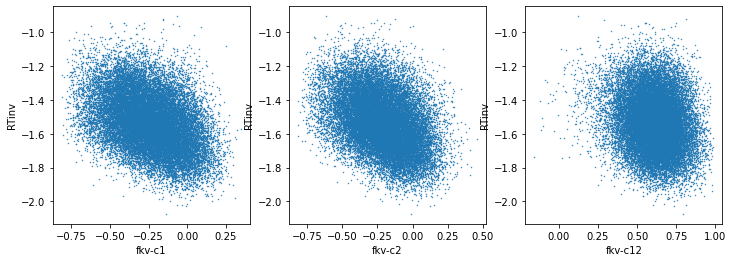

In [14]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
sim_df.plot.scatter("fkv-c1", "RTinv", s=0.2, ax=axes[0])
sim_df.plot.scatter("fkv-c2", "RTinv", s=0.2, ax=axes[1])
sim_df.plot.scatter("fkv-c12", "RTinv", s=0.2, ax=axes[2])

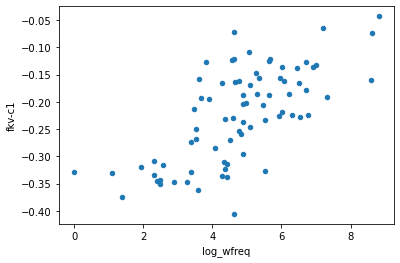

In [15]:
sim_df.loc[sim_df.Word_Trad.str.startswith("大"), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c1")

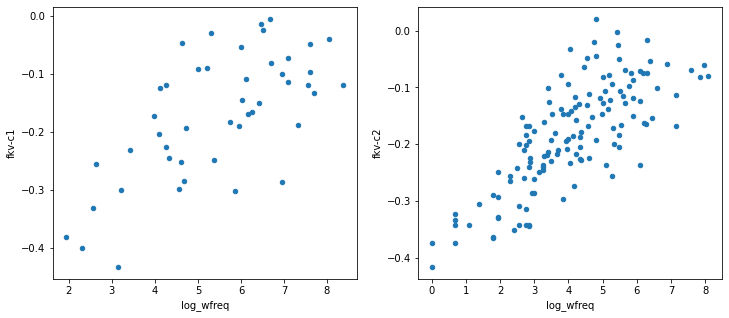

In [16]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
target_ch="人"
sim_df.loc[sim_df.Word_Trad.str.startswith(target_ch), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c1", ax=axes[0])
sim_df.loc[sim_df.Word_Trad.str.endswith(target_ch), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c2", ax=axes[1])

In [17]:
sim_df.loc[sim_df.Word_Trad.str.endswith("人"), :].sort_values("asbc_wfreq")

,Word_Trad,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-c12,fkv-isol.c1,fkv-isol.c2,log_wfreq,c1_type_logfreq,c2_type_logfreq,c1_token_logfreq,c2_token_logfreq
20100,鄙人,643.68,-1.553567,-0.54,0.25,1.0,-0.730911,-0.415096,0.439220,-0.578143,-0.349821,0.000000,2.484907,6.001415,-inf,8.218787
24695,蠢人,635.76,-1.572921,0.87,0.13,1.0,-0.716248,-0.373959,0.547334,-0.723812,-0.343719,0.000000,2.302585,6.001415,3.496508,8.218787
10665,差人,639.08,-1.564749,-1.60,0.32,2.0,-0.483156,-0.341776,0.584607,-0.494276,-0.303693,0.693147,3.433987,6.001415,4.094345,8.218787
17878,猿人,642.27,-1.556978,0.36,0.24,2.0,-0.589493,-0.373447,0.331386,-0.660636,-0.354207,0.693147,1.609438,6.001415,2.302585,8.218787
19033,寡人,632.83,-1.580203,0.38,-0.27,2.0,-0.699757,-0.323369,0.528426,-0.694618,-0.303888,0.693147,3.091042,6.001415,3.806662,8.218787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11366,病人,566.91,-1.763948,0.55,0.08,1267.0,0.198391,-0.167423,0.624016,-0.097869,-0.209388,7.144407,4.330733,6.001415,5.823046,8.218787
5775,男人,545.21,-1.834156,1.06,-0.03,1983.0,0.055693,-0.070001,0.732046,-0.069826,-0.184328,7.592366,4.094345,6.001415,5.049856,8.218787
4894,別人,570.93,-1.751528,-0.15,0.21,2545.0,-0.065766,-0.081565,0.697578,-0.096666,-0.135508,7.841886,3.401197,6.001415,6.021023,8.218787
496,女人,515.47,-1.939977,1.26,0.33,2897.0,0.037518,-0.060662,0.802899,-0.014960,-0.196321,7.971431,4.653960,6.001415,6.712956,8.218787


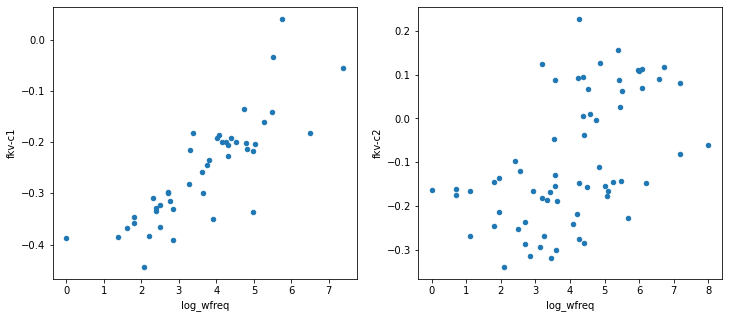

In [18]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
target_ch="長"
sim_df.loc[sim_df.Word_Trad.str.startswith(target_ch), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c1", ax=axes[0])
sim_df.loc[sim_df.Word_Trad.str.endswith(target_ch), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c2", ax=axes[1])

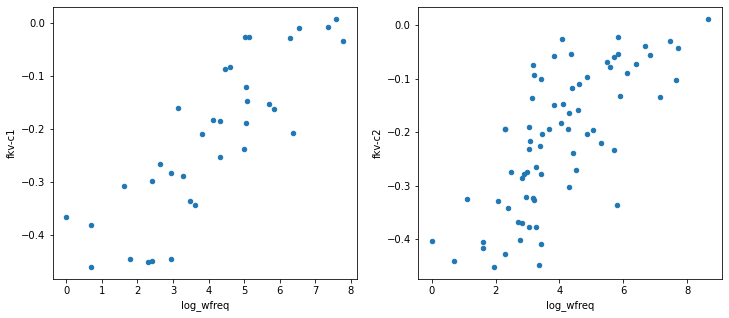

In [19]:
_, axes = plt.subplots(1, 2, figsize=(12,5))
target_ch="行"
sim_df.loc[sim_df.Word_Trad.str.startswith(target_ch), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c1", ax=axes[0])
sim_df.loc[sim_df.Word_Trad.str.endswith(target_ch), :].sort_values("asbc_wfreq").plot.scatter("log_wfreq", "fkv-c2", ax=axes[1])

In [20]:
fkv.similarity("/個.", ".人/"), fkv.similarity("/鄙.", ".人/"), fkv.similarity("/病.", ".人/")

(0.58482105, 0.43922013, 0.62401605)

## Grouping by frequency

In [21]:
simhf_df = sim_df.loc[sim_df.asbc_wfreq > 150, :]
print(simhf_df.shape)
simhf_df.head()

(4017, 16)


,Word_Trad,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-c12,fkv-isol.c1,fkv-isol.c2,log_wfreq,c1_type_logfreq,c2_type_logfreq,c1_token_logfreq,c2_token_logfreq
3,一切,560.91,-1.782817,-0.84,-1.28,2554.0,-0.165610,0.072127,0.562487,-0.216255,-0.340356,7.845416,5.446737,3.761200,9.490771,5.003946
7,一半,576.94,-1.733282,-2.02,0.77,715.0,-0.184805,-0.009384,0.662759,-0.173939,-0.147929,6.572283,5.446737,2.639057,9.490771,6.098074
8,一旦,639.57,-1.563551,-1.71,-0.87,1092.0,-0.228571,0.088540,0.234433,-0.215310,-0.350775,6.995766,5.446737,2.995732,9.490771,3.871201
9,一生,577.00,-1.733102,-1.17,-0.36,777.0,-0.129093,-0.115314,0.602708,-0.110845,-0.115496,6.655440,5.446737,5.429346,9.490771,8.413387
10,一共,729.32,-1.371140,-1.34,0.29,159.0,-0.228311,-0.248210,0.282647,-0.112503,0.123144,5.068904,5.446737,2.890372,9.490771,5.209486


In [22]:
simlf_df = sim_df.loc[sim_df.asbc_wfreq <= 150, :]
print(simlf_df.shape)
simlf_df.corr()

(19442, 16)


,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-c12,fkv-isol.c1,fkv-isol.c2,log_wfreq,c1_type_logfreq,c2_type_logfreq,c1_token_logfreq,c2_token_logfreq
RT,1.000000,0.989228,-0.075833,-0.022388,-0.349885,-0.253882,-0.271006,-0.130910,-0.179183,-0.186191,-0.392210,-0.114251,-0.106919,-0.075681,-0.100003
RTinv,0.989228,1.000000,-0.073771,-0.020436,-0.366064,-0.259673,-0.277730,-0.130309,-0.186787,-0.191255,-0.399775,-0.114291,-0.106761,-0.077405,-0.100900
ST-C1,-0.075833,-0.073771,1.000000,0.023746,0.000530,0.055235,0.022105,0.127196,-0.020427,0.039373,0.000217,-0.247431,0.098581,-0.281258,0.037461
ST-C2,-0.022388,-0.020436,0.023746,1.000000,-0.052220,-0.027276,-0.025489,0.134475,-0.052986,-0.076962,-0.057456,0.015689,-0.339748,-0.032210,-0.326054
asbc_wfreq,-0.349885,-0.366064,0.000530,-0.052220,1.000000,0.599735,0.566141,0.138941,0.425311,0.400800,0.843879,0.115450,0.060484,0.153686,0.113338
fkv-c1,-0.253882,-0.259673,0.055235,-0.027276,0.599735,1.000000,0.537380,0.145593,0.513634,0.382115,0.659951,0.305447,0.048950,0.301396,0.081853
fkv-c2,-0.271006,-0.277730,0.022105,-0.025489,0.566141,0.537380,1.000000,0.094435,0.386531,0.508062,0.639305,0.107468,0.320876,0.125307,0.316202
fkv-c12,-0.130910,-0.130309,0.127196,0.134475,0.138941,0.145593,0.094435,1.000000,0.055359,0.042715,0.158756,0.072866,-0.056518,-0.037622,-0.114034
fkv-isol.c1,-0.179183,-0.186787,-0.020427,-0.052986,0.425311,0.513634,0.386531,0.055359,1.000000,0.350520,0.479564,0.193613,0.050345,0.254390,0.047083
fkv-isol.c2,-0.186191,-0.191255,0.039373,-0.076962,0.400800,0.382115,0.508062,0.042715,0.350520,1.000000,0.470412,0.055800,0.245269,0.060582,0.232936


In [23]:
simhf_df.corr()

,RT,RTinv,ST-C1,ST-C2,asbc_wfreq,fkv-c1,fkv-c2,fkv-c12,fkv-isol.c1,fkv-isol.c2,log_wfreq,c1_type_logfreq,c2_type_logfreq,c1_token_logfreq,c2_token_logfreq
RT,1.000000,0.990311,-0.083278,-0.022805,-0.232723,-0.102610,-0.081366,-0.158236,0.047541,0.003835,-0.316037,-0.010743,-0.033823,0.028356,-0.031073
RTinv,0.990311,1.000000,-0.076973,-0.014923,-0.253214,-0.104296,-0.083459,-0.159614,0.039571,-0.001941,-0.338701,-0.008150,-0.034874,0.024569,-0.034013
ST-C1,-0.083278,-0.076973,1.000000,0.117107,-0.064535,0.289235,-0.060852,0.188878,0.118544,0.009161,-0.099410,-0.210834,0.089001,-0.284786,0.001719
ST-C2,-0.022805,-0.014923,0.117107,1.000000,-0.118016,-0.005231,0.269255,0.189616,-0.102402,0.051424,-0.142084,-0.044389,-0.269828,-0.122154,-0.246325
asbc_wfreq,-0.232723,-0.253214,-0.064535,-0.118016,1.000000,0.123198,0.099265,0.141805,0.059886,0.047574,0.785850,-0.000484,-0.001039,0.107252,0.094867
fkv-c1,-0.102610,-0.104296,0.289235,-0.005231,0.123198,1.000000,0.146489,0.210348,0.074008,-0.010016,0.238869,-0.299813,0.072692,-0.280081,0.087440
fkv-c2,-0.081366,-0.083459,-0.060852,0.269255,0.099265,0.146489,1.000000,0.202041,-0.023974,0.059363,0.188053,0.110097,-0.279068,0.073933,-0.235322
fkv-c12,-0.158236,-0.159614,0.188878,0.189616,0.141805,0.210348,0.202041,1.000000,-0.041722,-0.076433,0.170827,-0.136316,-0.151737,-0.150525,-0.167678
fkv-isol.c1,0.047541,0.039571,0.118544,-0.102402,0.059886,0.074008,-0.023974,-0.041722,1.000000,0.265707,0.075529,0.143345,0.122235,0.144764,0.070742
fkv-isol.c2,0.003835,-0.001941,0.009161,0.051424,0.047574,-0.010016,0.059363,-0.076433,0.265707,1.000000,0.056038,0.033646,0.195056,0.006337,0.125140


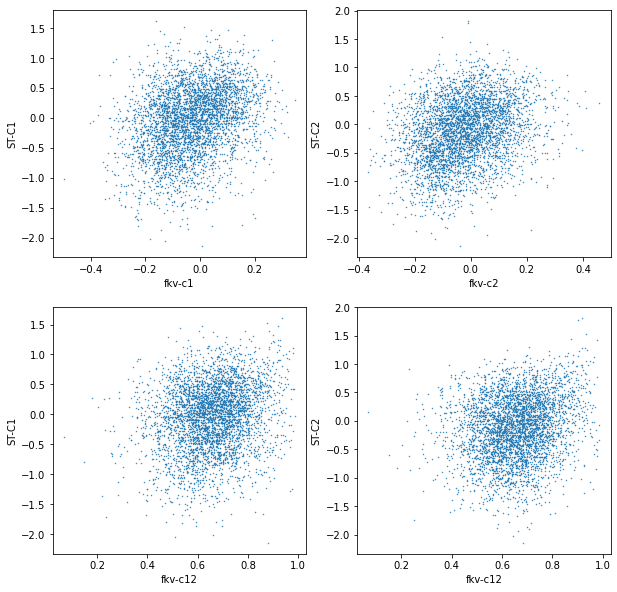

In [24]:
from matplotlib import pyplot as plt
_, axes = plt.subplots(2, 2, figsize=(10, 10))
simhf_df.plot.scatter("fkv-c1", "ST-C1", s=0.2, ax=axes[0][0])
simhf_df.plot.scatter("fkv-c2", "ST-C2", s=0.2, ax=axes[0][1])
simhf_df.plot.scatter("fkv-c12", "ST-C1", s=0.2, ax=axes[1][0])
simhf_df.plot.scatter("fkv-c12", "ST-C2", s=0.2, ax=axes[1][1])